In [1]:
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')
from sim import make_dataset
from slda import SLDA
from util import show_dataset

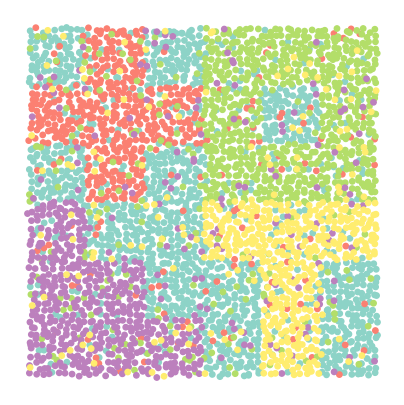

In [2]:
data, labels = make_dataset(('polygons'), (10, 15), wiggle=.25, mix=.25)
show_dataset(data, labels)

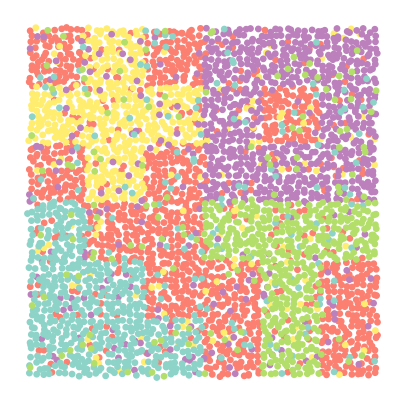

In [3]:
from sklearn.cluster import KMeans

topics = KMeans(5).fit_predict(data[:, 3:])
show_dataset(data, topics)

SLDA: 100%|██████████| 200/200 [00:47<00:00,  4.18it/s]


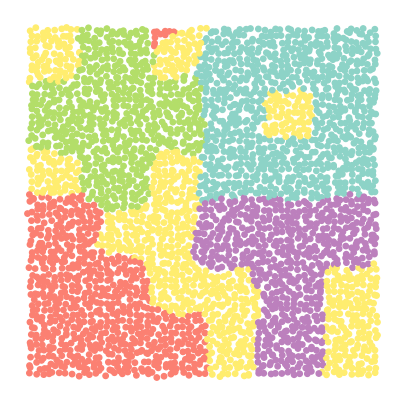

In [4]:
model = SLDA()
topics = model.fit_predict(data, n_steps=200, burn_in=150)
show_dataset(data, topics, figsize=5)

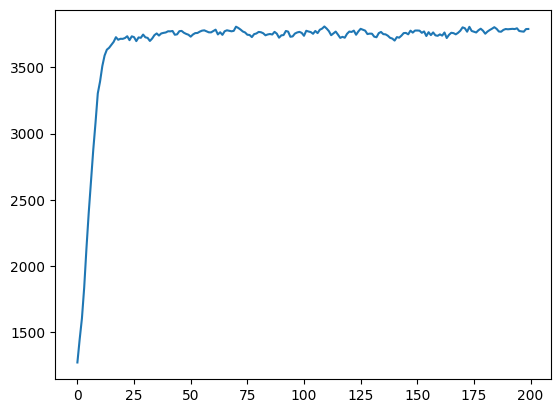

In [5]:
import numpy as np

x = np.arange(len(model.likelihood_log))
plt.plot(x, model.likelihood_log)
plt.show()